# Vehicle steering
Karl J. Astrom and Richard M. Murray  
23 Jul 2019

This notebook contains the computations for the vehicle steering running example in *Feedback Systems*.

RMM comments to Karl, 27 Jun 2019
* I'm using this notebook to walk through all of the vehicle steering examples and make sure that all of the parameters, conditions, and maximum steering angles are consitent and reasonable.
* Please feel free to send me comments on the contents as well as the bulletted notes, in whatever form is most convenient.
* Once we have sorted out all of the settings we want to use, I'll copy over the changes into the MATLAB files that we use for creating the figures in the book.
* These notes will be removed from the notebook once we have finalized everything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
ct.use_fbs_defaults()
ct.use_numpy_matrix(False)

## Vehicle steering dynamics (Example 3.11)

The vehicle dynamics are given by a simple bicycle model.  We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the vehicle in the plane and $\theta$ is the angle of the vehicle with respect to horizontal.  The vehicle input is given by $(v, \delta)$ where $v$ is the forward velocity of the vehicle and $\delta$ is the angle of the steering wheel.  We take as parameters the wheelbase $b$ and the offset $a$ between the rear wheels and the reference point. The model includes saturation of the vehicle steering angle (`maxsteer`).

* System state: `x`, `y`, `theta`
* System input: `v`, `delta`  
* System output: `x`, `y`  
* System parameters: `wheelbase`, `refoffset`, `maxsteer` 

Assuming no slipping of the wheels, the motion of the vehicle is given by a rotation around a point O that depends on the steering angle $\delta$.  To compute the angle $\alpha$ of the velocity of the reference point with respect to the axis of the vehicle, we let the distance from the center of rotation O to the contact point of the rear wheel be $r_\text{r}$ and it the follows from Figure 3.17 in FBS that $b = r_\text{r} \tan \delta$ and $a = r_\text{r} \tan \alpha$, which implies that $\tan \alpha = (a/b) \tan \delta$.

Reasonable limits for the steering angle depend on the speed.  The physical limit is given in our model as 0.5 radians (about 30 degrees).  However, this limit is rarely possible when the car is driving since it would cause the tires to slide on the pavement.  We us a limit of 0.1 radians (about 6 degrees) at 10 m/s ($\approx$ 35 kph) and 0.05 radians (about 3 degrees) at 30 m/s ($\approx$ 110 kph).  Note that a steering angle of 0.05 rad  gives a cross acceleration of $(v^2/b) \tan \delta \approx (100/3) 0.05 = 1.7$ $\text{m/s}^2$ at 10 m/s and 15 $\text{m/s}^2$ at 30 m/s ($\approx$ 1.5 times the force of gravity).

In [2]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    a = params.get('refoffset', 1.5)        # offset to vehicle reference point
    b = params.get('wheelbase', 3.)         # vehicle wheelbase
    maxsteer = params.get('maxsteer', 0.5)  # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -maxsteer, maxsteer)
    alpha = np.arctan2(a * np.tan(delta), b)

    # Return the derivative of the state
    return np.array([
        u[0] * np.cos(x[2] + alpha),    # xdot = cos(theta + alpha) v
        u[0] * np.sin(x[2] + alpha),    # ydot = sin(theta + alpha) v
        (u[0] / b) * np.tan(delta)      # thdot = v/l tan(phi)
    ])

def vehicle_output(t, x, u, params):
    return x[0:2]

# Default vehicle parameters (including nominal velocity)
vehicle_params={'refoffset': 1.5, 'wheelbase': 3, 'velocity': 15, 
                'maxsteer': 0.5}

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'delta'), outputs=('x', 'y'), params=vehicle_params)

## Vehicle driving on a curvy road (Figure 8.6a)

To illustrate the dynamics of the system, we create an input that correspond to driving down a curvy road.  This trajectory will be used in future simulations as a reference trajectory for estimation and control.

RMM notes, 27 Jun 2019:
* The figure below appears in Chapter 8 (output feedback) as Example 8.3, but I've put it here in the notebook since it is a good way to demonstrate the dynamics of the vehicle.
* In the book, this figure is created for the linear model and in a manner that I can't quite understand, since the linear model that is used is only for the lateral dynamics.  The original file is `OutputFeedback/figures/steering_obs.m`.
* To create the figure here, I set the initial vehicle angle to be $\theta(0) = 0.75$ rad and then used an input that gives a figure approximating Example 8.3  To create the lateral offset, I think subtracted the trajectory from the averaged straight line trajectory, shown as a dashed line in the $xy$ figure below.
* I find the approach that we used in the MATLAB version to be confusing, but I also think the method of creating the lateral error here is a hart to follow.  We might instead consider choosing a trajectory that goes mainly vertically, with the 2D dynamics being the $x$, $\theta$ dynamics instead of the $y$, $\theta$ dynamics.

KJA comments, 1 Jul 2019:

0. I think we should point out that the reference point is typically the projection of the center of mass of the whole vehicle.

1. The heading angle $\theta$ must be marked in Figure 3.17b.

2. I think it is useful to start with a curvy road that you have done here but then to specialized to a trajectory that is essentially horizontal, where $y$ is the deviation from the nominal horizontal $x$ axis. Assuming that $\alpha$ and $\theta$ are small we get the natural linearization of (3.26) $\dot x = v$ and $\dot y =v(\alpha + \theta)$

RMM response, 16 Jul 2019:
* I've changed the trajectory to be about the horizontal axis, but I am ploting things vertically for better figure layout.  This corresponds to what is done in Example 9.10 in the text, which I think looks OK.

KJA response, 20 Jul 2019: Fig 8.6a is fine

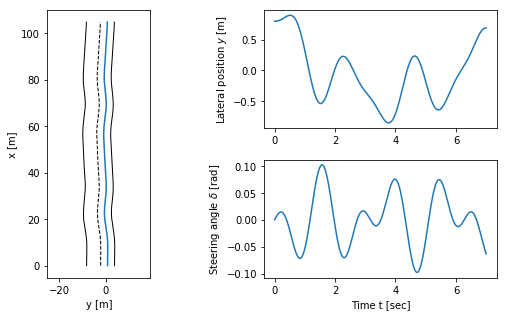

In [3]:
# System parameters
wheelbase = vehicle_params['wheelbase']
v0 = vehicle_params['velocity']

# Control inputs
T_curvy = np.linspace(0, 7, 500)
v_curvy = v0*np.ones(T_curvy.shape) 
delta_curvy = 0.1*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.0025*np.sin(T_curvy*np.pi/7)
u_curvy = [v_curvy, delta_curvy]
X0_curvy = [0, 0.8, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    vehicle, T_curvy, u_curvy, X0_curvy, params=vehicle_params, return_x=True)

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the resulting trajectory (and some road boundaries)
plt.subplot(1, 4, 2)
plt.plot(y_curvy[1], y_curvy[0])
plt.plot(y_curvy[1] - 9/np.cos(x_curvy[2]), y_curvy[0], 'k-', linewidth=1)
plt.plot(y_curvy[1] - 3/np.cos(x_curvy[2]), y_curvy[0], 'k--', linewidth=1)
plt.plot(y_curvy[1] + 3/np.cos(x_curvy[2]), y_curvy[0], 'k-', linewidth=1)

plt.xlabel('y [m]')
plt.ylabel('x [m]');
plt.axis('Equal')

# Plot the lateral position
plt.subplot(2, 2, 2)
plt.plot(t_curvy, y_curvy[1])
plt.ylabel('Lateral position $y$ [m]')

# Plot the steering angle
plt.subplot(2, 2, 4)
plt.plot(t_curvy, delta_curvy)
plt.ylabel('Steering angle $\\delta$ [rad]')
plt.xlabel('Time t [sec]')
plt.tight_layout()

## Linearization of lateral steering dynamics (Example 6.13)

We are interested in the motion of the vehicle about a straight-line path ($\theta = \theta_0$) with constant velocity $v_0 \neq 0$. To find the relevant equilibrium point, we first set $\dot\theta = 0$ and we see that we must have $\delta = 0$, corresponding to the steering wheel being straight. The motion in the xy plane is by definition not at equilibrium and so we focus on lateral deviation of the vehicle from a straight line. For simplicity, we let $\theta_\text{e} = 0$, which corresponds to driving along the $x$ axis. We can then focus on the equations of motion in the $y$ and $\theta$ directions with input $u = \delta$.

In [4]:
# Define the lateral dynamics as a subset of the full vehicle steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: vehicle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: vehicle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('phi'), outputs=('y', 'theta')
)

# Compute the linearization at velocity 10 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=vehicle_params)

# Normalize dynamics using state [x1/b, x2] and timescale v0 t / b
b = vehicle_params['wheelbase']
v0 = vehicle_params['velocity']
lateral_transformed = ct.similarity_transform(
    lateral_linearized, [[1/b, 0], [0, 1]], timescale=v0/b)

# Set the output to be the normalized state x1/b
lateral_normalized = lateral_transformed[0,:] * (1/b)
print("Linearized system dynamics:\n")
print(lateral_normalized)

# Save the system matrices for later use
A = lateral_normalized.A
B = lateral_normalized.B
C = lateral_normalized.C

Linearized system dynamics:

A = [[0. 1.]
 [0. 0.]]

B = [[0.5]
 [1. ]]

C = [[1. 0.]]

D = [[0.]]



## Eigenvalue placement controller design (Example 7.4)

We want to design a controller that stabilizes the dynamics of the vehicle and tracks a given reference value $r$ of the lateral position of the vehicle.  We use feedback to design the dynamics of the system to have the characteristic polynomial
$p(s) = s^2 + 2 \zeta_\text{c} \omega_\text{c} + \omega_\text{c}^2$.

To find reasonable values of $\omega_\text{c}$ we observe that the initial response of the steering angle to a unit step change in the steering command is $\omega_\text{c}^2 r$, where $r$ is the commanded lateral transition. Recall that the model is normalized so that the length unit is the wheelbase $b$ and the time unit is the time $b/v_0$ to travel one wheelbase. A typical car has a wheelbase of about 3 m and, assuming a speed of 30 m/s, a normalized time unit corresponds to 0.1 s. To determine a reasonable steering angle when making a gentle lane change, we assume that the turning radius is $R$ = 600 m. For a wheelbase of 3 m this corresponds to a steering angle $\delta \approx 3/600 = 0.005$ rad and a lateral acceleration of $v^2/R$ = 302/600 = 1.5 m/s$^2$. Assuming that a lane change corresponds to a translation of one wheelbase we find $\omega_\text{c} = \sqrt{0.005}$ = 0.07 rad/s.

The unit step responses for the closed loop system for different values of the design parameters are shown below. The effect of $\omega_c$ is shown on the left, which shows that the response speed increases with increasing $\omega_\text{c}$. All responses have overshoot less than 5% (15 cm), as indicated by the dashed lines. The settling times range from 30 to 60 normalized time units, which corresponds to about 3–6 s, and are limited by the acceptable lateral acceleration of the vehicle. The effect of $\zeta_\text{c}$ is shown on the right. The response speed and the overshoot increase with decreasing damping. Using these plots, we conclude that a reasonable design choice is $\omega_\text{c} = 0.07$ and $\zeta_\text{c} = 0.7$. 

RMM note, 27 Jun 2019: 
* The design guidelines are for $v_0$ = 30 m/s (highway speeds) but most of the examples below are done at lower speed (typically 10 m/s).  Also, the eigenvalue locations above are not the same ones that we use in the output feedback example below.  We should probably make things more consistent.

KJA comment, 1 Jul 2019: 
* I am all for maikng it consist and choosing e.g. v0 = 30 m/s

RMM comment, 17 Jul 2019:
* I've updated the examples below to use v0 = 30 m/s for everything except the forward/reverse example.  This corresponds to ~105 kph (freeway speeds) and a reasonable bound for the steering angle to avoid slipping is 0.05 rad.

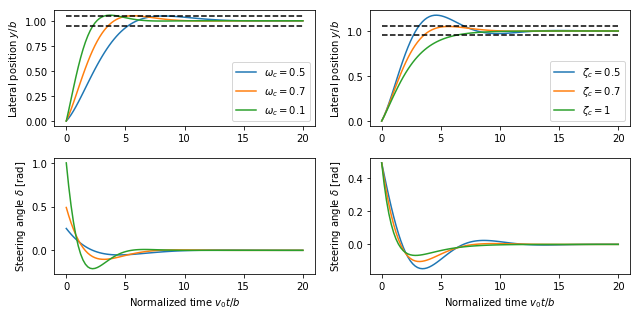

In [5]:
# Utility function to place poles for the normalized vehicle steering system
def normalized_place(wc, zc):
    # Get the dynamics and input matrices, for later use
    A, B = lateral_normalized.A, lateral_normalized.B
    
    # Compute the eigenvalues from the characteristic polynomial
    eigs = np.roots([1, 2*zc*wc, wc**2])
    
    # Compute the feedback gain using eigenvalue placement
    K = ct.place_varga(A, B, eigs)
    
    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, lateral_normalized.C, 0)
    
    # Compute the feedforward gain based on the zero frequency gain of the closed loop
    kf = np.real(1/clsys.evalfr(0))

    # Scale the input by the feedforward gain
    clsys *= kf
    
    # Return gains and closed loop system dynamics
    return K, kf, clsys

# Utility function to plot simulation results for normalized vehicle steering system
def normalized_plot(t, y, u, inpfig, outfig):
    plt.sca(outfig)
    plt.plot(t, y)
    plt.sca(inpfig)
    plt.plot(t, u[0])
    
# Utility function to label plots of normalized vehicle steering system 
def normalized_label(inpfig, outfig):
    plt.sca(inpfig)
    plt.xlabel('Normalized time $v_0 t / b$')
    plt.ylabel('Steering angle $\delta$ [rad]')

    plt.sca(outfig)
    plt.ylabel('Lateral position $y/b$')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Explore range of values for omega_c, with zeta_c = 0.7
outfig = plt.subplot(2, 2, 1)
inpfig = plt.subplot(2, 2, 3)
zc = 0.7
for wc in [0.5, 0.7, 1]:
    # Place the poles of the system
    K, kf, clsys = normalized_place(wc, zc)
    
    # Compute the step response
    t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)
        
    # Compute the input used to generate the control response
    u = -K @ x + kf * 1

    # Plot the results
    normalized_plot(t, y, u, inpfig, outfig)
    
# Add labels to the figure
normalized_label(inpfig, outfig)
plt.legend(('$\omega_c = 0.5$', '$\omega_c = 0.7$', '$\omega_c = 0.1$'))

# Explore range of values for zeta_c, with omega_c = 0.07
outfig = plt.subplot(2, 2, 2)
inpfig = plt.subplot(2, 2, 4)
wc = 0.7
for zc in [0.5, 0.7, 1]:
    # Place the poles of the system
    K, kf, clsys = normalized_place(wc, zc)
    
    # Compute the step response
    t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)
        
    # Compute the input used to generate the control response
    u = -K @ x + kf * 1

    # Plot the results
    normalized_plot(t, y, u, inpfig, outfig)
    
# Add labels to the figure
normalized_label(inpfig, outfig)
plt.legend(('$\zeta_c = 0.5$', '$\zeta_c = 0.7$', '$\zeta_c = 1$'))
plt.tight_layout()

RMM notes, 17 Jul 2019
* These step responses are *very* slow.  Note that the steering wheel angles are about 10X less than a resonable bound (0.05 rad at 30 m/s).  A consequence of these low gains is that the tracking controller in Example 8.4 has to use a different set of gains.  We could update, but the gains listed here have a rationale that we would have to update as well.
* Based on the discussion below, I think we should make $\omega_\text{c}$ range from 0.5 to 1 (10X faster).

KJA response, 20 Jul 2019: Makes a lot of sense to make $\omega_\text{c}$ range from 0.5 to 1 (10X faster). The plots were still in the range 0.05 to 0.1 in the note you sent me.

RMM response: 23 Jul 2019: Updated $\omega_\text{c}$ to 10X faster.  Note that this makes size of the inputs for the step response quite large, but that is in part because a unit step in the desired position produces an (instantaneous) error of $b = 3$ m $\implies$ quite a large error.  A lateral error of 10 cm with $\omega_c = 0.7$ would produce an (initial) input of 0.015 rad.

## Eigenvalue placement observer design (Example 8.3)

We construct an estimator for the (normalized) lateral dynamics by assigning the eigenvalues of the estimator dynamics to desired value, specifified in terms of the second order characteristic equation for the estimator dynamics.

In [6]:
# Find the eigenvalue from the characteristic polynomial
wo = 1          # bandwidth for the observer
zo = 0.7        # damping ratio for the observer
eigs = np.roots([1, 2*zo*wo, wo**2])
    
# Compute the estimator gain using eigenvalue placement
L = np.transpose(
    ct.place(np.transpose(A), np.transpose(C), eigs))
print("L = ", L)

# Create a linear model of the lateral dynamics driving the estimator
est = ct.StateSpace(A - L @ C, np.block([[B, L]]), np.eye(2), np.zeros((2,2)))

L =  [[1.4]
 [1. ]]


### Linear observer applied to nonlinear system output

A simulation of the observer for a vehicle driving on a curvy road is shown below. The first figure shows the trajectory of the vehicle on the road, as viewed from above. The response of the observer is shown on the right, where time is normalized to the vehicle length. We see that the observer error settles in about 4 vehicle lengths.

RMM note, 27 Jun 2019:
* As an alternative, we can attempt to estimate the state of the full nonlinear system using a linear estimator.  This system does not necessarily converge to zero since there will be errors in the nominal dynamics of the system for the linear estimator.
* The limits on the $x$ axis for the time plots are different to show the error over the entire trajectory.
* We should decide whether we want to keep the figure above or the one below for the text.

KJA comment, 1 Jul 2019:
* I very much like your observation about the nonlinear system. I think it is a very good idea to use your new simulation

RMM comment, 17 Jul 2019: plan to use this version in the text.

KJA comment, 20 Jul 2019: I think this is a big improvement we show that an observer based on a linearized model works on a nonlinear simulation, If possible we could add a line telling why the linear model works and that this is standard procedure in control engineering.	

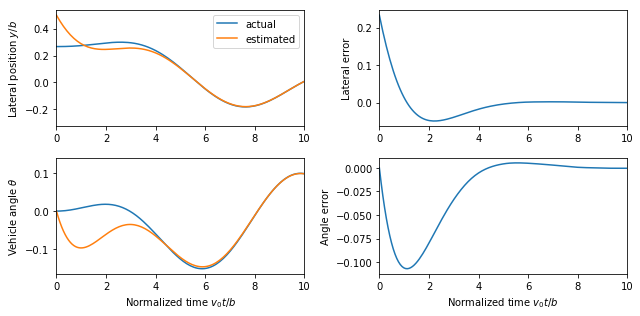

In [7]:
# Convert the curvy trajectory into normalized coordinates
x_ref = x_curvy[0] / wheelbase
y_ref = x_curvy[1] / wheelbase
theta_ref = x_curvy[2]
tau = v0 * T_curvy / b

# Simulate the estimator, with a small initial error in y position
t, y_est, x_est = ct.forced_response(est, tau, [delta_curvy, y_ref], [0.5, 0])

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the actual and estimated states
ax = plt.subplot(2, 2, 1)
plt.plot(t, y_ref)
plt.plot(t, x_est[0])
ax.set(xlim=[0, 10])
plt.legend(['actual', 'estimated'])
plt.ylabel('Lateral position $y/b$')

ax = plt.subplot(2, 2, 2)
plt.plot(t, x_est[0] - y_ref)
ax.set(xlim=[0, 10])
plt.ylabel('Lateral error')

ax = plt.subplot(2, 2, 3)
plt.plot(t, theta_ref)
plt.plot(t, x_est[1])
ax.set(xlim=[0, 10])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Vehicle angle $\\theta$')

ax = plt.subplot(2, 2, 4)
plt.plot(t, x_est[1] - theta_ref)
ax.set(xlim=[0, 10])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Angle error')
plt.tight_layout()

## Output Feedback Controller (Example 8.4)

RMM note, 27 Jun 2019
* The feedback gains for the controller below are different that those computed in the eigenvalue placement example (from Ch 7), where an argument was given for the choice of the closed loop eigenvalues.  Should we choose a single, consistent set of gains in both places?
* This plot does not quite match Example 8.4 because a different reference is being used for the laterial position.
* The transient in $\delta$ is quiet large.  This appears to be due to the error in $\theta(0)$, which is initialized to zero intead of to `theta_curvy`.

KJA comment, 1 Jul 2019:
1. The large initial errors dominate the plots.

2. There is somehing funny happening at the end of the simulation, may be due to the small curvature at the end of the path?

RMM comment, 17 Jul 2019:
* Updated to use the new trajectory
* We will have the issue that the gains here are different than the gains that we used in Chapter 7.  I think that what we need to do is update the gains in Ch 7 (they are too sluggish, as noted above).
* Note that unlike the original example in the book, the errors do not converge to zero.  This is because we are using pure state feedback (no feedforward) => the controller doesn't apply any input until there is an error.

KJA comment, 20 Jul 2019: We may add that state feedback is a proportional controller which does not guarantee that the error goes to zero for example by changing the line "The tracking error ..." to "The tracking error can be improved by adding integral action (Section7.4), later in this chapter "Disturbance Modeling" or feedforward (Section 8,5). Should we do an exercises? 	

K =  [[0.49   0.7448]]
kf =  [[0.49]]


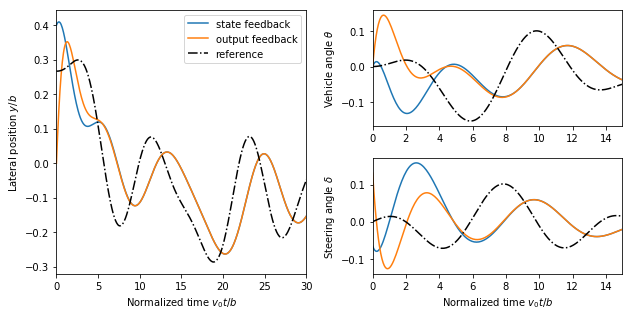

In [8]:
# Compute the feedback gains
# K, kf, clsys = normalized_place(1, 0.707)     # Gains from MATLAB
# K, kf, clsys = normalized_place(0.07, 0.707)  # Original gains
K, kf, clsys = normalized_place(0.7, 0.707)       # Final gains

# Print out the gains
print("K = ", K)
print("kf = ", kf)

# Construct an output-based controller for the system
clsys = ct.StateSpace(
    np.block([[A, -B@K], [L@C, A - B@K - L@C]]),
    np.block([[B], [B]]) * kf, 
    np.block([[C, np.zeros(C.shape)], [np.zeros(C.shape), C]]), 
    np.zeros((2,1)))

# Simulate the system
t, y, x = ct.forced_response(clsys, tau, y_ref, [0.4, 0, 0.0, 0])

# Calcaluate the input used to generate the control response
u_sfb = kf * y_ref - K @ x[0:2]
u_ofb = kf * y_ref - K @ x[2:4]

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the actual and estimated states
ax = plt.subplot(1, 2, 1)
plt.plot(t, x[0])
plt.plot(t, x[2])
plt.plot(t, y_ref, 'k-.')
ax.set(xlim=[0, 30])
plt.legend(['state feedback', 'output feedback', 'reference'])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Lateral position $y/b$')

ax = plt.subplot(2, 2, 2)
plt.plot(t, x[1])
plt.plot(t, x[3])
plt.plot(t, theta_ref, 'k-.')
ax.set(xlim=[0, 15])
plt.ylabel('Vehicle angle $\\theta$')

ax = plt.subplot(2, 2, 4)
plt.plot(t, u_sfb[0])
plt.plot(t, u_ofb[0])
plt.plot(t, delta_curvy, 'k-.')
ax.set(xlim=[0, 15])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Steering angle $\\delta$')
plt.tight_layout()

## Trajectory Generation (Example 8.8)

To illustrate how we can use a two degree-of-freedom design to improve the performance of the system, consider the problem of steering a car to change lanes on a road.  We use the non-normalized form of the dynamics, which were derived in Example 3.11.

KJA comment, 1 Jul 2019:
1. I think the reference trajectory is too much curved in the end compare with Example 3.11

In summary I think it is OK to change the reference trajectories but we should make sure that the curvature is less than $\rho=600 m$ not to have too high acceleratarion.

RMM response, 16 Jul 2019:
* Not sure if the comment about the trajectory being too curved is referring to this example.  The steering angles (and hence radius of curvature/acceleration) are quite low.  ??

KJA response, 20 Jul 2019: You are right the curvature is not too small. We could add the sentence "The small deviations can be eliminated by adding feedback."

RMM response, 23 Jul 2019: I think the small deviation you are referring to is in the velocity trace.  This occurs because I gave a fixed endpoint in time and so the velocity had to be adjusted to hit that exact point at that time.  This doesn't show up in the book, so it won't be a problem ($\implies$ no additional explanation required).

In [9]:
import control.flatsys as fs

# Function to take states, inputs and return the flat flag
def vehicle_flat_forward(x, u, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)
    
    # Create a list of arrays to store the flat output and its derivatives
    zflag = [np.zeros(3), np.zeros(3)]
    
    # Flat output is the x, y position of the rear wheels
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]
    
    # First derivatives of the flat output
    zflag[0][1] = u[0] * np.cos(x[2])  # dx/dt
    zflag[1][1] = u[0] * np.sin(x[2])  # dy/dt
    
    # First derivative of the angle
    thdot = (u[0]/b) * np.tan(u[1])

    # Second derivatives of the flat output (setting vdot = 0)
    zflag[0][2] = -u[0] * thdot * np.sin(x[2])
    zflag[1][2] =  u[0] * thdot * np.cos(x[2])
    
    return zflag

# Function to take the flat flag and return states, inputs
def vehicle_flat_reverse(zflag, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)  

    # Create a vector to store the state and inputs
    x = np.zeros(3)
    u = np.zeros(2)
    
    # Given the flat variables, solve for the state
    x[0] = zflag[0][0]  # x position
    x[1] = zflag[1][0]  # y position
    x[2] = np.arctan2(zflag[1][1], zflag[0][1])  # tan(theta) = ydot/xdot
    
    # And next solve for the inputs
    u[0] = zflag[0][1] * np.cos(x[2]) + zflag[1][1] * np.sin(x[2])
    thdot_v = zflag[1][2] * np.cos(x[2]) - zflag[0][2] * np.sin(x[2])
    u[1] = np.arctan2(thdot_v, u[0]**2 / b)
    
    return x, u

vehicle_flat = fs.FlatSystem(vehicle_flat_forward, vehicle_flat_reverse, inputs=2, states=3)

To find a trajectory from an initial state $x_0$ to a final state $x_\text{f}$ in time $T_\text{f}$ we solve a point-to-point trajectory generation problem.  We also set the initial and final inputs, which sets the vehicle velocity $v$ and steering wheel angle $\delta$ at the endpoints.

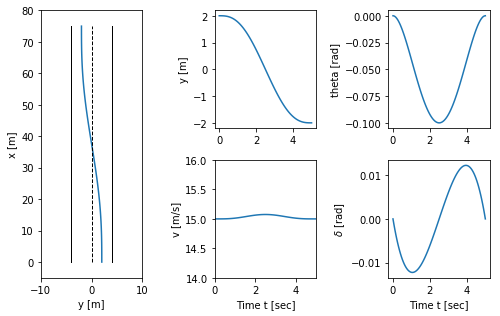

In [13]:
# Define the endpoints of the trajectory 
x0 = [0., 2., 0.]; u0 = [15, 0.]
xf = [75, -2., 0.]; uf = [15, 0.]
Tf = xf[0] / uf[0]

# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(6)

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle_flat, x0, u0, xf, uf, Tf, basis=poly)

# Create the trajectory
t = np.linspace(0, Tf, 100)
x, u = traj.eval(t)

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the trajectory in xy coordinate
plt.subplot(1, 4, 2)
plt.plot(x[1], x[0])
plt.xlabel('y [m]')
plt.ylabel('x [m]')

# Add lane lines and scale the axis
plt.plot([-4, -4], [0, x[0, -1]], 'k-', linewidth=1)
plt.plot([0, 0], [0, x[0, -1]], 'k--', linewidth=1)
plt.plot([4, 4], [0, x[0, -1]], 'k-', linewidth=1)
plt.axis([-10, 10, -5, x[0, -1] + 5])

# Time traces of the state and input
plt.subplot(2, 4, 3)
plt.plot(t, x[1])
plt.ylabel('y [m]')

plt.subplot(2, 4, 4)
plt.plot(t, x[2])
plt.ylabel('theta [rad]')

plt.subplot(2, 4, 7)
plt.plot(t, u[0])
plt.xlabel('Time t [sec]')
plt.ylabel('v [m/s]')
plt.axis([0, Tf, u0[0] - 1, uf[0] +1])

plt.subplot(2, 4, 8)
plt.plot(t, u[1]);
plt.xlabel('Time t [sec]')
plt.ylabel('$\delta$ [rad]')
plt.tight_layout()

## Vehicle transfer functions for forward and reverse driving (Example 10.11)

The vehicle steering model has different properties depending on whether we are driving forward or in reverse.  The figures below show step responses from steering angle to lateral translation for a the linearized model when driving forward (dashed) and reverse (solid). In this simulation we have added an extra pole with the time constant $T=0.1$ to approximately account for the dynamics in the steering system.

With rear-wheel steering the center of mass first moves in the wrong direction and the overall response with rear-wheel steering is significantly delayed compared with that for front-wheel steering. (b) Frequency response for driving forward (dashed) and reverse (solid). Notice that the gain curves are identical, but the phase curve for driving in reverse has non-minimum phase.

RMM note, 27 Jun 2019:
* I cannot recreate the figures in Example 10.11.  Since we are looking at the lateral *velocity*, there is a differentiator in the output and this takes the step function and creates an offset at $t = 0$ (intead of a smooth curve).
* The transfer functions are also different, and I don't quite understand why.  Need to spend a bit more time on this one.

KJA comment, 1 Jul 2019: The reason why you cannot recreate figures i Example 10.11 is because the caption in figure is wrong, sorry my fault, the y-axis should be lateral position not lateral velocity. The approximate expression for the transfer functions

$$
G_{y\delta}=\frac{av_0s+v_0^2}{bs} = \frac{1.5 s + 1}{3s^2}=\frac{0.5s + 0.33}{s}
$$

are quite close to the values that you get numerically

In this case I think it is useful to have v=1 m/s because we do not drive to fast backwards.

RMM response, 17 Jul 2019
* Updated figures below use the same parameters as the running example (the current text uses different parameters)
* Following the material in the text, a pole is added at s = -1 to approximate the dynamics of the steering system.  This is not strictly needed, so we could decide to take it out (and update the text)

KJA comment, 20 Jul 2019: I have been oscillating a bit about this example. Of course it does not make sense to drive in reverse in 30 m/s but it seems a bit silly to change parameters just in this case (if we do we have to motivate it). On the other hand what we are doing is essentially based on transfer functions and a RHP zero. My current view which has changed a few times is to keep the standard parameters. In any case we should eliminate the extra time constant. A small detail, I could not see the time response in the file you sent, do not resend it!, I will look at the final version.

RMM comment, 23 Jul 2019: I think it is OK to have the speed be different and just talk about this in the text.  I have removed the extra time constant in the current version.

In [24]:
# Magnitude of the steering input (half maximum)
Msteer = vehicle_params['maxsteer'] / 2

# Create a linearized model of the system going forward at 2 m/s
forward_lateral = ct.linearize(lateral, [0, 0], [0], params={'velocity': 2})
forward_tf = ct.ss2tf(forward_lateral)[0, 0]
print("Forward TF = ", forward_tf)

# Create a linearized model of the system going in reverise at 1 m/s
reverse_lateral = ct.linearize(lateral, [0, 0], [0], params={'velocity': -2})
reverse_tf = ct.ss2tf(reverse_lateral)[0, 0]
print("Reverse TF = ", reverse_tf)

Forward TF =  
          s + 1.333
-----------------------------
s^2 + 7.828e-16 s - 1.848e-16

Reverse TF =  
          -s + 1.333
-----------------------------
s^2 - 7.828e-16 s - 1.848e-16



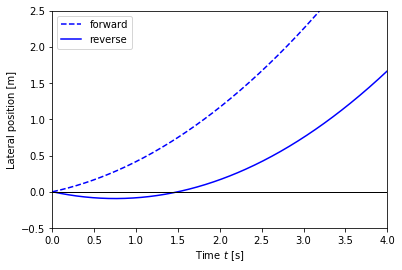

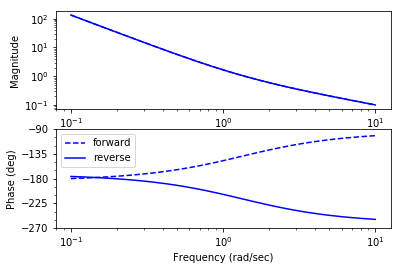

In [25]:
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure()

# Forward motion
t, y = ct.step_response(forward_tf * Msteer, np.linspace(0, 4, 500))
plt.plot(t, y, 'b--')

# Reverse motion
t, y = ct.step_response(reverse_tf * Msteer, np.linspace(0, 4, 500))
plt.plot(t, y, 'b-')

# Add labels and reference lines
plt.axis([0, 4, -0.5, 2.5])
plt.legend(['forward', 'reverse'], loc='upper left')
plt.xlabel('Time $t$ [s]')
plt.ylabel('Lateral position [m]')
plt.plot([0, 4], [0, 0], 'k-', linewidth=1)

# Plot the Bode plots
plt.figure()
plt.subplot(1, 2, 2)
ct.bode_plot(forward_tf[0, 0], np.logspace(-1, 1, 100), color='b', linestyle='--', 
             initial_phase=-180)
ct.bode_plot(reverse_tf[0, 0], np.logspace(-1, 1, 100), color='b', linestyle='-',
             initial_phase=-180);
plt.legend(('forward', 'reverse'));


## Feedforward Compensation (Example 12.6)

For a lane transfer system we would like to have a nice response without overshoot, and we therefore consider the use of feedforward compensation to provide a reference trajectory for the closed loop system.  We choose the desired response as $F_\text{m}(s) = a^22/(s + a)^2$, where the response speed or aggressiveness of the steering is governed by the parameter $a$.

RMM note, 27 Jun 2019:
* $a$ was used in the original description of the dynamics as the reference offset.  Perhaps choose a different symbol here?
* In current version of Ch 12, the $y$ axis is labeled in absolute units, but it should actually be in normalized units, I think.
* The steering angle input for this example is quite high.  Compare to Example 8.8, above.  Also, we should probably make the size of the "lane change" from this example match whatever we use in Example 8.8

KJA comments, 1 Jul 2019: Chosen parameters look good to me

RMM response, 17 Jul 2019
* I changed the time constant for the feedforward model to give something that is more reasonable in terms of turning angle at the speed of $v_0 = 30$ m/s.  Note that this takes about 30 body lengths to change lanes (= 9 seconds at 105 kph).
* The time to change lanes is about 2X what it is using the differentially flat trajectory above.  This is mainly because the feedback controller applies a large pulse at the beginning of the trajectory (based on the input error), whereas the differentially flat trajectory spreads the turn over a longer interval.  Since are living the steering angle, we have to limit the size of the pulse => slow down the time constant for the reference model.

KJA response, 20 Jul 2019: I think the time for lane change is too long, which may depend on the small steering angles used. The largest steering angle is about 0.03 rad, but we have admitted larger values in previous examples. I suggest that we change the design so that the largest sterring angel is closer to 0.05, see the remark from Bjorn O a lane change could take about 5 s at 30m/s. 

RMM response, 23 Jul 2019: I reset the time constant to 0.2, which gives something closer to what we had for trajectory generation.  It is still slower, but this is to be expected since it is a linear controller.  We now finish the trajectory in 20 body lengths, which is about 6 seconds.

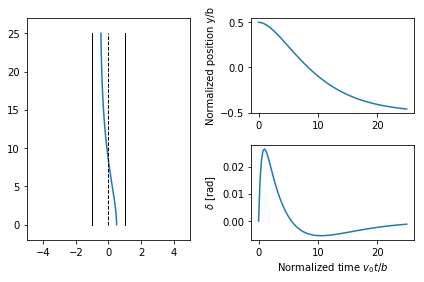

In [56]:
# Define the desired response of the system
a = 0.2
P = ct.ss2tf(lateral_normalized)
Fm = ct.TransferFunction([a**2], [1, 2*a, a**2])
Fr = Fm / P

# Compute the step response of the feedforward components
t, y_ffwd = ct.step_response(Fm, np.linspace(0, 25, 100))
t, delta_ffwd = ct.step_response(Fr, np.linspace(0, 25, 100))

# Scale and shift to correspond to lane change (-2 to +2)
y_ffwd = 0.5 - 1 * y_ffwd
delta_ffwd *= 1

# Overhead view
plt.subplot(1, 2, 1)
plt.plot(y_ffwd, t)
plt.plot(-1*np.ones(t.shape), t, 'k-', linewidth=1)
plt.plot(0*np.ones(t.shape), t, 'k--', linewidth=1)
plt.plot(1*np.ones(t.shape), t, 'k-', linewidth=1)
plt.axis([-5, 5, -2, 27])

# Plot the response
plt.subplot(2, 2, 2)
plt.plot(t, y_ffwd)
# plt.axis([0, 10, -5, 5])
plt.ylabel('Normalized position y/b')

plt.subplot(2, 2, 4)
plt.plot(t, delta_ffwd)
# plt.axis([0, 10, -1, 1])
plt.ylabel('$\\delta$ [rad]')
plt.xlabel('Normalized time $v_0 t / b$');

plt.tight_layout()

## Fundamental Limits (Example 14.13)

Consider a controller based on state feedback combined with an observer where we want a faster closed loop system and choose $\omega_\text{c} = 10$, $\zeta_\text{c} = 0.707$, $\omega_\text{o} = 20$, and $\zeta_\text{o} = 0.707$.

KJA comment, 20 Jul 2019: This is a really troublesome case. If we keep it as a vehicle steering problem we must have an order of magnitude lower valuer for $\omega_c$ and $\omega_o$ and then the zero will not be slow. My recommendation is to keep it as a general system with the transfer function. $P(s)=(s+1)/s^2$. The text then has to be reworded.

RMM response, 23 Jul 2019: I think the way we have it is OK.  Our current value for the controller and observer is $\omega_\text{c} = 0.7$ and $\omega_\text{o} = 1$.  Here we way we want something faster and so we got to $\omega_\text{c} = 7$ (10X) and $\omega_\text{o} = 10$ (10X).

K =  [100.   -35.86]
L =  [ 28.28 400.  ]
C(s) =  
-1.152e+04 s + 4e+04
--------------------
s^2 + 42.42 s + 6658



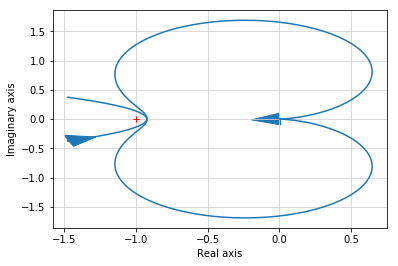

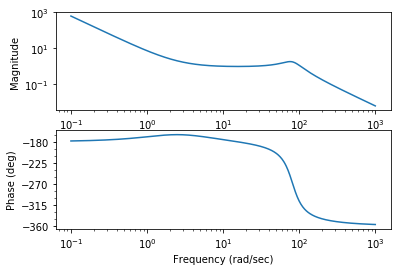

In [15]:
# Compute the feedback gain using eigenvalue placement
wc = 10
zc = 0.707
eigs = np.roots([1, 2*zc*wc, wc**2])
K = ct.place(A, B, eigs)
kr = np.real(1/clsys.evalfr(0))
print("K = ", np.squeeze(K))

# Compute the estimator gain using eigenvalue placement
wo = 20
zo = 0.707
eigs = np.roots([1, 2*zo*wo, wo**2])
L = np.transpose(
    ct.place(np.transpose(A), np.transpose(C), eigs))
print("L = ", np.squeeze(L))

# Construct an output-based controller for the system
C1 = ct.ss2tf(ct.StateSpace(A - B@K - L@C, L, K, 0))
print("C(s) = ", C1)

# Compute the loop transfer function and plot Nyquist, Bode
L1 = P * C1
plt.figure(); ct.nyquist_plot(L1, np.logspace(0.5, 3, 500))
plt.figure(); ct.bode_plot(L1, np.logspace(-1, 3, 500));

In [16]:
# Modified control law
wc = 10
zc = 2.6
eigs = np.roots([1, 2*zc*wc, wc**2])
K = ct.place(A, B, eigs)
kr = np.real(1/clsys.evalfr(0))
print("K = ", np.squeeze(K))

# Construct an output-based controller for the system
C2 = ct.ss2tf(ct.StateSpace(A - B@K - L@C, L, K, 0))
print("C(s) = ", C2)

K =  [100.   2.]
C(s) =  
    3628 s + 4e+04
---------------------
s^2 + 80.28 s + 156.6



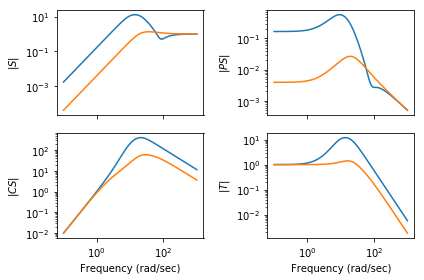

In [17]:
# Plot the gang of four for the two designs
ct.gangof4(P, C1, np.logspace(-1, 3, 100))
ct.gangof4(P, C2, np.logspace(-1, 3, 100))